In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import conrad
import cvxpy
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
from conrad import Case, CasePlotter, D
from os import path

In [3]:
dirpath = '/home/anqi/Documents/Papers/conrad_paper/figures/'

def cross_percentile(data, dose):
    idx = (np.abs(data['curve']['dose'] - dose)).argmin()
    return data['curve']['percentile'][idx]

def plot_data(data, title=None, color='blue', label='organ', show=True, plotfile=None):
    max_dose = data['curve']['dose'].max()
    plt.plot(data['curve']['dose'], data['curve']['percentile'], color=color, label=label)
    if title is not None: plt.title(title)
    for constraint in data['constraints']:
        if constraint[1]['type'] is 'percentile':
            plt.plot(constraint[1]['dose'][0], constraint[1]['percentile'][0], constraint[1]['symbol'], label='_nolegend_', alpha=0.55, color=color, markersize=12)
            plt.plot(constraint[1]['dose'][1], constraint[1]['percentile'][1], constraint[1]['symbol'], label='_nolegend_', color=color, markersize=12)
            
            xline = constraint[1]['dose'][0]
            yline = constraint[1]['percentile'][0]
            ycross = cross_percentile(data, xline)
            
            plt.axvline(x=xline, ymin=0, ymax=max(yline, ycross)/103.0, linewidth=1, color='black', linestyle='dotted', label='_nolegend_')
            plt.axhline(y=yline, xmin=0, xmax=xline/(1.1 * max_dose), linewidth=1, color='black', linestyle='dotted', label='_nolegend_')
            plt.axhline(y=ycross, xmin=0, xmax=xline/(1.1 * max_dose), linewidth=1, color='black', linestyle='dotted', label='_nolegend_')
        max_dose = max(max_dose, constraint[1]['dose'][0])
    plt.xlim(0, 1.1 * max_dose)
    plt.ylim(0, 103)
     
    if plotfile is not None:
        filepath = path.abspath(dirpath + plotfile)
        plt.savefig(filepath, bbox_inches = 'tight')
    if show: plt.show()

In [4]:
# Define dimensions of problem
m_target = 100
m_oar = 400
m = m_target + m_oar
n = 200

# Structure labels
lab_tum = 0
lab_oar = 1

# Generate random beam matrix
A_target = 1.2 * np.random.rand(m_target, n)
A_oar = 0.3 * np.random.rand(m_oar, n)
A = np.vstack((A_target, A_oar))

label_order = [lab_tum, lab_oar]
voxel_labels = [lab_tum] * m_target + [lab_oar] * m_oar

In [5]:
# Prescription for each structure
rx = [{'label': lab_tum, 'name': 'tumor', 'is_target': True,  'dose': 1., 'constraints': None},
      {'label': lab_oar, 'name': 'oar',   'is_target': False, 'dose': 0., 'constraints': None}]

In [68]:
# Construct and a case with DVH constraints
cs = Case(A, voxel_labels, label_order, rx)
cs.structures[lab_tum].constraints += D(80) >= 0.85
cs.structures[lab_oar].constraints += D(30) <= 0.23
p = CasePlotter(cs)


 SolverCVXPY.BUILD CALL: EXACT= False
(100, 200)
(100, 200)
(400, 200)
(400, 200)

 SolverCVXPY.__ADD_CONSTRAINTS CALL: EXACT= False

 SolverCVXPY.__ADD_CONSTRAINTS CALL: RESTRICTION BRANCH

ADDING RESTRICTED CONSTRAINT
sum_entries(max_elemwise(var292 + -1 * [[ 1.05551317  1.01667415  0.01083941 ...,  0.75355439  0.55213405
   0.06706248]
 [ 0.19546014  0.83562345  0.24596436 ...,  1.16944015  0.87944938
   0.14171703]
 [ 0.69572951  0.23650627  0.68804409 ...,  0.97262731  0.0495669
   0.85334757]
 ..., 
 [ 0.71498861  0.22032381  1.1510956  ...,  0.77915445  0.91152941
   1.19563323]
 [ 0.57852521  0.98025543  0.37935439 ...,  0.70422108  0.83197882
   0.20779554]
 [ 0.77004555  0.67648347  0.67509031 ...,  0.25842446  0.99826449
   0.82866838]] * var289 + -0.85, 0)) <= 20.0 * var292

 SolverCVXPY.__ADD_CONSTRAINTS CALL: EXACT= False

 SolverCVXPY.__ADD_CONSTRAINTS CALL: RESTRICTION BRANCH

ADDING RESTRICTED CONSTRAINT
sum_entries(max_elemwise(var297 + 1 * [[ 0.02446533  0.10332455 

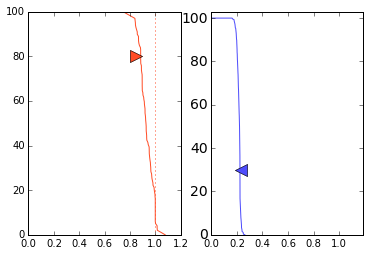

In [69]:
# Solve without slacks using a single pass
cs.plan(solver = "ECOS", dvh_slack = False, dvh_2pass = False)
p.set_display_groups(grouping = 'separate')
p.plot(cs)

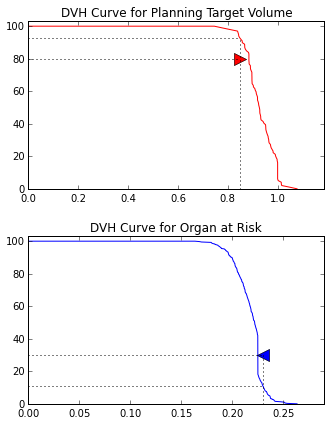

In [88]:
plt.figure(figsize = (4.8,6))
plt.subplot(2,1,1)
plot_data(cs.plotting_data[0], title = 'DVH Curve for Planning Target Volume', color = 'red', label = 'ptv', show = False)
plt.subplot(2,1,2)
plt.tight_layout(h_pad=3.0)
plot_data(cs.plotting_data[1], title = 'DVH Curve for Organ at Risk', color = 'blue', label = 'oar', show = True)